# Business Problem

A bank requested a machine learning model that would produce results on whether loan applicants among the bank's customers would get the loan or not.

Data Quality                                                                                
Descriptive Statistics
Modelling
Evaluation

1. Data Quality
It is the dataset that contains information about customers and we will work on deriving useful insights from the information and predicting whether a new customer will accept a loan offer.

1 - age: The age of the customer, must be over 18(numeric)

2 - job: customer is profession(categorical)

admin.
blue-collar
entrepreneur
housemaid
management
self-employed
retired
services
student
technician
unemployed
unknown
3 - marital: marital status(categorical)

married
single
divorced Note: 'divorced' means divorced or widowed
4 - education: educational status(categorical)

primary
secondary
tertiary
unknown
5 - balance: bank balance

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - campaign: number of contacts performed during this campaign and for this client (numeric)

8 - deposit: did the customer get a loan? (binary: 'yes', 'no')

9 - duration: contact time in seconds (numeric)

Libraries

In [1]:
!pip install lazypredict

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import lazypredict
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import matplotlib.pyplot as pyplot
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
def load():
    df = pd.read_csv('data/bank.csv')
    return df

df = load()

df = df.drop(labels = ['default', 'contact', 'day', 'month', 'pdays', 'previous', 'loan', 'poutcome', 'poutcome'], axis=1)

Overview

In [4]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(11162, 9)
##################### Types #####################
age           int64
job          object
marital      object
education    object
balance       int64
housing      object
duration      int64
campaign      int64
deposit      object
dtype: object
##################### Head #####################
   age         job  marital  education  balance housing  duration  campaign  \
0   59      admin.  married  secondary     2343     yes      1042         1   
1   56      admin.  married  secondary       45      no      1467         1   
2   41  technician  married  secondary     1270     yes      1389         1   
3   55    services  married  secondary     2476     yes       579         1   
4   54      admin.  married   tertiary      184      no       673         2   

  deposit  
0     yes  
1     yes  
2     yes  
3     yes  
4     yes  
##################### NA #####################
age          0
job          0
marital      0
educati

Capture of Numerical and Category Variables

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

        Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
        Note: Categorical variables include categorical variables with numeric appearance.

        Parameters
        ------
            dataframe: dataframe
                    Dataframe to get variable names
            cat_th: int, optional
                    class threshold for numeric but categorical variables
            car_th: int, optinal
                    class threshold for categorical but cardinal variables

        Returns
        ------
            cat_cols: list
                    Categorical variable list
            num_cols: list
                    Numeric variable list
            cat_but_car: list
                    List of cardinal variables with categorical view

        Examples
        ------
            import seaborn as sns
            df = sns.load_dataset("iris")
            print(grab_col_names(df))


        Notes
        ------
            cat_cols + num_cols + cat_but_car = total number of variables
            num_but_cat is inside cat_cols.
            The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

        """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"observations: {dataframe.shape[0]}")
    print(f"variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 11162
variables: 9
cat_cols: 5
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [6]:
cat_cols

['job', 'marital', 'education', 'housing', 'deposit']

In [7]:
num_cols

['age', 'balance', 'duration', 'campaign']

#### Summary
When the NA and Quantiles outputs are checked after running the check_df function, it is known that there are no missing observations but there are outliers.

The minimum age variable will be assumed to be 18, because the minimum age to get a loan from banks is 18 (This assumption is made because the age limit for many countries is 18, but for absolute accuracy, it is necessary to know the country where the data comes from, for which the relevant department should be contacted).

Since age cannot be a negative value, improvements should be made if necessary.

Will we check for outliers? It has also been observed that some age data is unrealistically high.(e.g. 416 and 338)
The duration column should also be examined, and the duration column should not be a negative value.

In [8]:
df.age.unique()

array([59, 56, 41, 55, 54, 42, 60, 37, 28, 38, 30, 29, 46, 31, 35, 32, 49,
       43, 26, 40, 33, 23, 48, 45, 36, 52, 53, 39, 57, 51, 44, 24, 50, 27,
       34, 47, 25, 58, 61, 68, 75, 22, 69, 66, 85, 72, 90, 67, 71, 21, 74,
       65, 62, 83, 70, 76, 77, 19, 73, 63, 20, 78, 95, 64, 79, 82, 18, 86,
       84, 87, 92, 81, 80, 93, 88, 89])

In [9]:
df.duration.unique

<bound method Series.unique of 0        1042
1        1467
2        1389
3         579
4         673
5         562
6        1201
7        1030
8         608
9        1297
10        786
11       1574
12       1689
13       1102
14        943
15       1084
16        541
17       1119
18       1120
19        513
20        442
21        756
22       2087
23       1120
24        985
25        617
26        483
27        929
28        538
29        710
30        653
31       1028
32        654
33       1692
34        665
35        757
36        504
37       1346
38        568
39        395
40       1015
41        683
42        470
43       1001
44        845
45        945
46       1721
47        942
48        476
49        832
50       1553
51       1328
52       1125
53        858
54        629
55        704
56        760
57        930
58       1028
59        850
60        927
61       1423
62       1162
63        755
64        695
65        483
66        520
67        920
68        500
69 

In [10]:
df.campaign.unique()

array([ 1,  2,  3,  4,  6,  5,  8, 11,  9, 10, 15, 12, 14,  7, 24, 13, 17,
       29, 21, 20, 16, 32, 19, 25, 22, 43, 18, 41, 63, 27, 30, 26, 23, 28,
       33, 31])

#### Outlier Analysis

In [11]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [12]:
outlier_thresholds(df, "age")

(-26.5, 113.5)

In [13]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [14]:
grab_outliers(df, "age")

Empty DataFrame
Columns: [age, job, marital, education, balance, housing, duration, campaign, deposit]
Index: []


### Outlier Check

In [15]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [16]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
balance True
duration True
campaign True


In [17]:
num_cols1 = ['age', 'duration', 'campaign']

### Delete Outlier

In [18]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

Threshold ranges are given, observations outside the up and down values are dropped.

In [19]:
for col in num_cols1:
     df = remove_outlier(df, col)
     
# Check
for col in num_cols1:
      print(col, check_outlier(df, col))

age False
duration True
campaign True


### Descriptive Statistics

#### Analysis of Categorical Variables

                job  Ratio
management     2545 22.978
blue-collar    1924 17.371
technician     1810 16.342
admin.         1324 11.954
services        915  8.261
retired         775  6.997
self-employed   403  3.638
student         358  3.232
unemployed      357  3.223
entrepreneur    324  2.925
housemaid       271  2.447
unknown          70  0.632


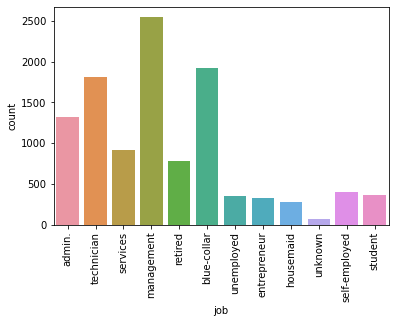

          marital  Ratio
married      6300 56.880
single       3497 31.573
divorced     1279 11.547


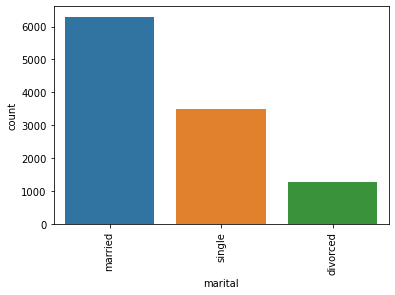

           education  Ratio
secondary       5438 49.097
tertiary        3663 33.072
primary         1483 13.389
unknown          492  4.442


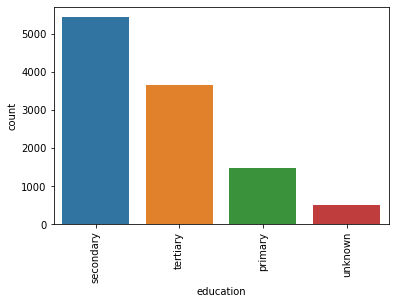

     housing  Ratio
no      5845 52.772
yes     5231 47.228


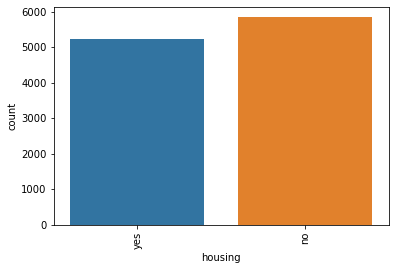

     deposit  Ratio
no      5809 52.447
yes     5267 47.553


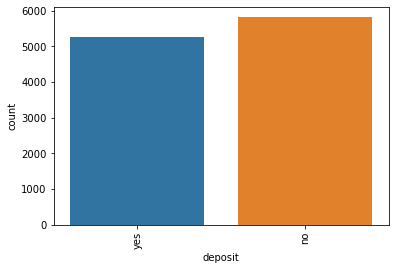

In [20]:
def cat_summary(dataframe, col_name, plot=False):
     print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                         "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
     if plot:
         sns.countplot(x=dataframe[col_name], data=dataframe)
         plt.xticks(rotation=90)
         plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)

#### Analysis of Numerical Variables

count   11076.000
mean       41.238
std        11.920
min        18.000
5%         26.000
10%        28.000
20%        31.000
30%        33.000
40%        36.000
50%        39.000
60%        42.000
70%        47.000
90%        58.000
95%        61.000
99%        77.000
max        93.000
Name: age, dtype: float64


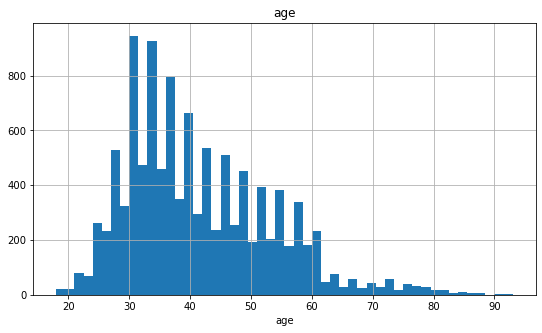

count   11076.000
mean     1529.380
std      3223.726
min     -6847.000
5%        -53.250
10%         0.000
20%        63.000
30%       191.000
40%       340.000
50%       553.000
60%       863.000
70%      1344.000
90%      3904.000
95%      6018.750
99%     13119.250
max     81204.000
Name: balance, dtype: float64


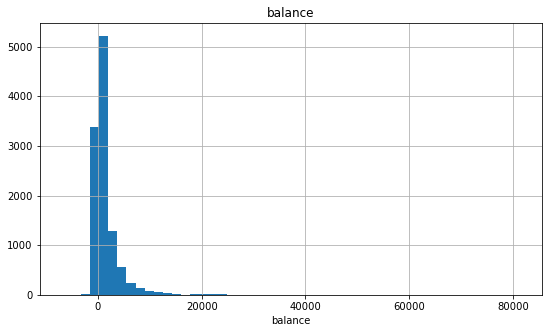

count   11076.000
mean      370.370
std       335.653
min         2.000
5%         53.000
10%        78.000
20%       120.000
30%       160.000
40%       205.000
50%       256.000
60%       324.000
70%       421.000
90%       837.000
95%      1074.000
99%      1555.250
max      2621.000
Name: duration, dtype: float64


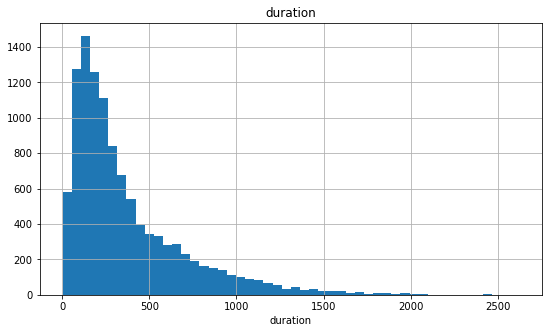

count   11076.000
mean        2.369
std         2.040
min         1.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         2.000
60%         2.000
70%         2.000
90%         5.000
95%         6.000
99%        11.000
max        16.000
Name: campaign, dtype: float64


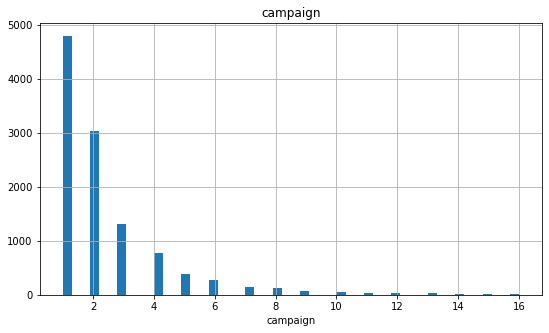

In [21]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50, figsize=(9,5))
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, True)

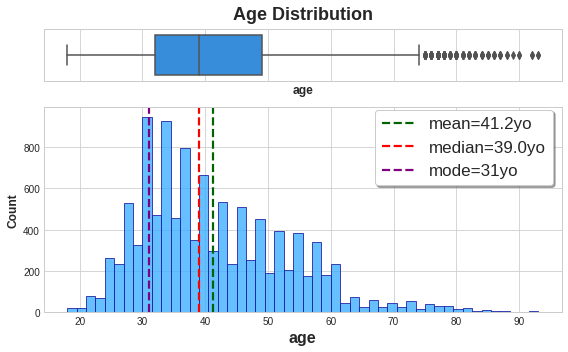

In [22]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0],color = "#1D8EF5")
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1],color = "#33AAFF", edgecolor="#1D1EA2")
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='darkgreen', linestyle='--',linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color='red', linestyle='--',linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color='purple', linestyle='--',linewidth=2.2, label='mode='+ str(np.round(df[col].mode()[0],1)) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()

num_plot(df, 'age', 'Age Distribution', 'yo')
